# FPP optimization workflow 

In [111]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Debug);

## Make new FPP equilibirum from scratch

### Initialize from FPP v1_demount

In [112]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:ITER, init_from=:scalars);

### Modify ini

In [113]:
ini.nbi.power_launched = 20e6
ini.ec_launchers.power_launched = 30e6
ini.ic_antennas.power_launched = 0e6

ini

FUSE.ParametersInits{Float64}
├─ general
│  ├─ casename ➡ "ITER_scalars" Mnemonic name of the case being run
│  └─ init_from ➡ :scalars Initialize run from [:ods, :scalars]
├─ time
│  ├─ pulse_shedule_time_basis ➡ LinRange{Float64}(0.0, 300.0, 1000) [s] Time basis used to discretize the pulse schedule
│  └─ simulation_start ➡ 250.0 [s] Time at which the simulation starts
├─ gasc
│  ├─ filename ➡ missing Output GASC .json file from which data will be loaded
│  └─ case ➡ missing Number of the GASC run to load
├─ ods
│  └─ filename ➡ missing ODS.json file from which equilibrium is loaded
├─ build
│  ├─ layers ➡ OrderedCollections.OrderedDict{Symbol, Float64}(
│  │           :gap_OH => 0.8
│  │           :OH => 1.275
│  │           :gap_OH_TF => 0.05
│  │           :hfs_TF => 1.075
│  │           :hfs_vacuum_vessel => 0.3
│  │           :hfs_shield => 0.4
│  │           :hfs_wall => 0.1
│  │           :plasma => 4.4
│  │           :lfs_wall => 0.1
│  │           :lfs_shield => 0.4
│  │    

In [114]:
act.ActorECsimple.rho_0 = 0.0

act

FUSE.ParametersActors{Float64}
├─ ActorARIESCosting
│  ├─ land_space ➡ 1000.0 [acres] Plant site space required
│  ├─ building_volume ➡ 140000.0 [m^3] Volume of the tokmak building
│  ├─ interest_rate ➡ 0.05 Annual interest rate fraction of direct capital cost
│  ├─ indirect_cost_rate ➡ 0.4 Indirect cost associated with construction, equipment, services, engineering construction
│  │  management and owners cost
│  ├─ escalation_fraction ➡ 0.05 Yearly escalation fraction based on risk assessment
│  └─ blanket_lifetime ➡ 6.8 [year] Lifetime of the blanket
├─ ActorBalanceOfPlant
│  ├─ generator_conversion_efficiency ➡ 0.95 Efficiency of the generator
│  └─ do_plot ➡ false Plot
├─ ActorBlanket
│  ├─ minimum_first_wall_thickness ➡ 0.02 [m] Minimum first wall thickness
│  ├─ blanket_multiplier ➡ 1.2 Neutron thermal power multiplier in blanket
│  ├─ thermal_power_extraction_efficiency ➡ 1.0 Fraction of thermal power that is carried out by the coolant at the blanket
│  │  interface, rather tha

### Modify act

In [115]:
act.ActorEquilibrium.model = :TEQUILA
act.ActorTEQUILA.free_boundary = false

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.error_on_performance = false

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :none


act.ActorCoreTransport.model = :FluxMatcher
act.ActorFluxMatcher.do_plot = false
act.ActorFluxMatcher.verbose = false

act.ActorStationaryPlasma.convergence_error = 1e-2
act.ActorStationaryPlasma.max_iter = 5
act.ActorStationaryPlasma.do_plot = true
act.ActorStationaryPlasma.verbose = true

act.ActorFluxMatcher


ActorFluxMatcher{Float64}
├─ rho_transport ➡ 0.25:0.1:0.85 ρ transport grid
├─ evolve_Ti ➡ :flux_match Ion temperature `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_Te ➡ :flux_match Electron temperature `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_densities ➡ :flux_match Densities `:fixed`, or electron flux-match and rest match ne scale `:flux_match`, or Dict
│  to specify which species are `:flux_match`, kept `:fixed`, used to enforce `:quasi_neutrality`, or scaled to
│  `:match_ne_scale`
├─ evolve_rotation ➡ :fixed Rotation `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_pedestal ➡ false Evolve the pedestal inside the transport solver
├─ optimize_q ➡ false Optimize q profile to achieve goal
├─ max_iterations ➡ 200 Maximum optimizer iterations
├─ optimizer_algorithm ➡ :trust_region Optimizing algorithm used for the flux matching [:anderson, :newton, :trust_region]
├─ step_size ➡ 0.5 Step size for each algorithm iteration (note this has

## Run WholeFacility Actor

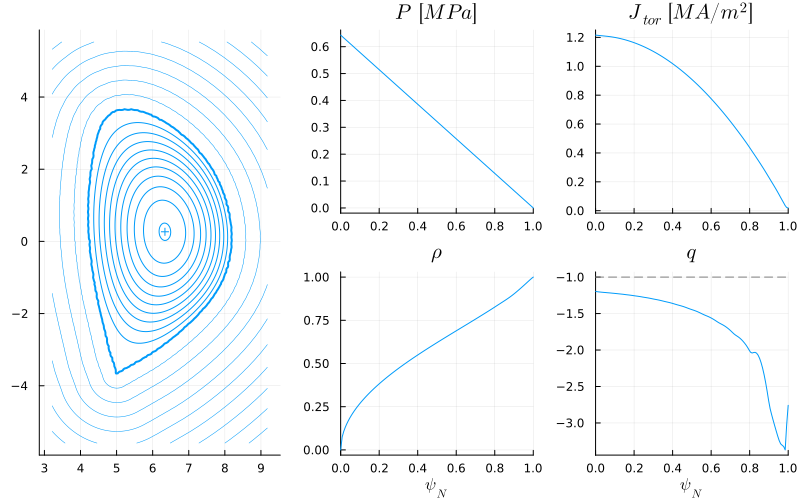

ErrorException: Equilibrium does not allow building the right number of upper (0→0) and lower (1→0) divertors.

In [117]:
dd = IMAS.dd()
@time FUSE.init(dd, ini, act; do_plot=false);
display(IMAS.extract(dd))

In [118]:
@time FUSE.ActorHFSsizing(dd, act);

IMASDD.IMASbadExpression: Bad expression build.layer[14].outline.r
Did not find build.layer: name=nothing type=nothing identifier=-18 fs=_lfs_
Stacktrace:
  [1] error(s::String)
    @ Base ./error.jl:35
  [2] #get_build_layer#227
    @ ~/.julia/dev/IMAS/src/physics/build.jl:103 [inlined]
  [3] get_build_layer
    @ ~/.julia/dev/IMAS/src/physics/build.jl:93 [inlined]
  [4] (::IMAS.var"#778#780")(x::Vector{Float64}; build::IMASDD.build{Float64}, layer::IMASDD.build__layer{Float64}, ::@Kwargs{outline::IMASDD.build__layer___outline{Float64}, dd::IMASDD.dd{Float64}, layer_index::Int64})
    @ IMAS ~/.julia/dev/IMAS/src/expressions/dynamic.jl:410
  [5] exec_expression_with_ancestor_args(ids::IMASDD.IDS, field::Symbol, func::Function)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:892
  [6] _getproperty(ids::IMASDD.IDS, field::Symbol)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:568
  [7] getproperty(ids::IMASDD.IDS, field::Symbol)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:295
  [8] macro expansion
    @ ~/.julia/dev/IMAS/src/plot.jl:657 [inlined]
  [9] apply_recipe(plotattributes::AbstractDict{Symbol, Any}, bd::IMASDD.build)
    @ IMAS ~/.julia/packages/RecipesBase/BRe07/src/RecipesBase.jl:300
 [10] _process_userrecipes!(plt::Any, plotattributes::Any, args::Any)
    @ RecipesPipeline ~/.julia/packages/RecipesPipeline/BGM3l/src/user_recipe.jl:38
 [11] recipe_pipeline!(plt::Any, plotattributes::Any, args::Any)
    @ RecipesPipeline ~/.julia/packages/RecipesPipeline/BGM3l/src/RecipesPipeline.jl:72
 [12] _plot!(plt::Plots.Plot, plotattributes::Any, args::Any)
    @ Plots ~/.julia/packages/Plots/sxUvK/src/plot.jl:223
 [13] #plot#188
    @ ~/.julia/packages/Plots/sxUvK/src/plot.jl:102 [inlined]
 [14] plot
    @ ~/.julia/packages/Plots/sxUvK/src/plot.jl:93 [inlined]
 [15] FUSE.ActorHFSsizing(dd::IMASDD.dd{Float64}, act::FUSE.ParametersActors{Float64}; kw::@Kwargs{})
    @ FUSE ~/julia_dev/FUSE/src/actors/build/hfs_actor.jl:37
 [16] FUSE.ActorHFSsizing(dd::IMASDD.dd{Float64}, act::FUSE.ParametersActors{Float64})
    @ FUSE ~/julia_dev/FUSE/src/actors/build/hfs_actor.jl:34
 [17] macro expansion
    @ ./timing.jl:279 [inlined]
 [18] top-level scope
    @ ~/julia_dev/FUSE/playground/weisberg_FPP_build/ITER_build_TEQUILA_tglfnn.ipynb:1
 [19] eval
    @ ./boot.jl:383 [inlined]
 [20] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
    @ Base ./loading.jl:2070
 [21] #invokelatest#2
    @ ./essentials.jl:887 [inlined]
 [22] invokelatest
    @ ./essentials.jl:884 [inlined]
 [23] (::VSCodeServer.var"#202#203"{VSCodeServer.NotebookRunCellArguments, String})()
    @ VSCodeServer ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/VSCodeServer/src/serve_notebook.jl:19
 [24] withpath(f::VSCodeServer.var"#202#203"{VSCodeServer.NotebookRunCellArguments, String}, path::String)
    @ VSCodeServer ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/VSCodeServer/src/repl.jl:274
 [25] notebook_runcell_request(conn::VSCodeServer.JSONRPC.JSONRPCEndpoint{Base.PipeEndpoint, Base.PipeEndpoint}, params::VSCodeServer.NotebookRunCellArguments)
    @ VSCodeServer ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/VSCodeServer/src/serve_notebook.jl:13
 [26] dispatch_msg(x::VSCodeServer.JSONRPC.JSONRPCEndpoint{Base.PipeEndpoint, Base.PipeEndpoint}, dispatcher::VSCodeServer.JSONRPC.MsgDispatcher, msg::Dict{String, Any})
    @ VSCodeServer.JSONRPC ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/JSONRPC/src/typed.jl:67
 [27] serve_notebook(pipename::String, outputchannel_logger::Base.CoreLogging.SimpleLogger; crashreporting_pipename::String)
    @ VSCodeServer ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/VSCodeServer/src/serve_notebook.jl:139
 [28] top-level scope
    @ ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/notebook/notebook.jl:32
 [29] include(mod::Module, _path::String)
    @ Base ./Base.jl:489
 [30] exec_options(opts::Base.JLOptions)
    @ Base ./client.jl:318
 [31] _start()
    @ Base ./client.jl:552

## Summary

In [119]:
#redirect_stdio(stdout="timing.txt") do
#    show(FUSE.timer)
#end
show(FUSE.timer)

In [120]:
display(IMAS.extract(dd))
FUSE.digest(dd)

GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 6.2 [m]                   B0 → -5.3 [T]                  Te0 → 16.1 [keV]               ne0 → 1.32e+20 [m⁻³]           
a → 1.98 [m]                   ip → 14.9 [MA]                 Ti0 → 16.1 [keV]               ne_ped → 8.15e+19 [m⁻³]        
1/ϵ → 3.12                     q95 → -3.22                    <Te> → 6.8 [keV]               <ne> → 9.98e+19 [m⁻³]          
κ → 1.85                       <Bpol> → 1.01 [T]              <Ti> → 6.8 [keV]               ne0/<ne> → 1.32                
δ → 0.483                      βpol_MHD → 0.686               Te0/<Te> → 2.37                fGW → 0.902                    
ζ → -0.0952                    βtor_MHD → 0.0253              Ti0/<Ti> → 2.37                zeff_ped → 2                   


IMASDD.IMASbadExpression: Bad expression build.layer[14].outline.r
Did not find build.layer: name=nothing type=nothing identifier=-18 fs=_lfs_
Stacktrace:
  [1] error(s::String)
    @ Base ./error.jl:35
  [2] #get_build_layer#227
    @ ~/.julia/dev/IMAS/src/physics/build.jl:103 [inlined]
  [3] get_build_layer
    @ ~/.julia/dev/IMAS/src/physics/build.jl:93 [inlined]
  [4] (::IMAS.var"#778#780")(x::Vector{Float64}; build::IMASDD.build{Float64}, layer::IMASDD.build__layer{Float64}, ::@Kwargs{outline::IMASDD.build__layer___outline{Float64}, dd::IMASDD.dd{Float64}, layer_index::Int64})
    @ IMAS ~/.julia/dev/IMAS/src/expressions/dynamic.jl:410
  [5] exec_expression_with_ancestor_args(ids::IMASDD.IDS, field::Symbol, func::Function)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:892
  [6] _getproperty(ids::IMASDD.IDS, field::Symbol)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:568
  [7] getproperty(ids::IMASDD.IDS, field::Symbol)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:295
  [8] macro expansion
    @ ~/.julia/dev/IMAS/src/plot.jl:657 [inlined]
  [9] apply_recipe(plotattributes::AbstractDict{Symbol, Any}, bd::IMASDD.build)
    @ IMAS ~/.julia/packages/RecipesBase/BRe07/src/RecipesBase.jl:300
 [10] _process_userrecipes!(plt::Any, plotattributes::Any, args::Any)
    @ RecipesPipeline ~/.julia/packages/RecipesPipeline/BGM3l/src/user_recipe.jl:38
 [11] recipe_pipeline!(plt::Any, plotattributes::Any, args::Any)
    @ RecipesPipeline ~/.julia/packages/RecipesPipeline/BGM3l/src/RecipesPipeline.jl:72
 [12] _plot!(plt::Plots.Plot, plotattributes::Any, args::Any)
    @ Plots ~/.julia/packages/Plots/sxUvK/src/plot.jl:223
 [13] plot!(plt::Plots.Plot, args::Any; kw...)
    @ Plots ~/.julia/packages/Plots/sxUvK/src/plot.jl:213
 [14] plot!(sp::Plots.Subplot, args::Any; kw...)
    @ Plots ~/.julia/packages/Plots/sxUvK/src/plot.jl:295
 [15] plot!
    @ ~/.julia/packages/Plots/sxUvK/src/plot.jl:292 [inlined]
 [16] digest(dd::IMASDD.dd{Float64}; terminal_width::Int64, line_char::Char, section::Int64)
    @ FUSE ~/julia_dev/FUSE/src/utils_end.jl:285
 [17] digest(dd::IMASDD.dd{Float64})
    @ FUSE ~/julia_dev/FUSE/src/utils_end.jl:268
 [18] top-level scope
    @ ~/julia_dev/FUSE/playground/weisberg_FPP_build/ITER_build_TEQUILA_tglfnn.ipynb:2
 [19] eval
    @ ./boot.jl:383 [inlined]
 [20] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
    @ Base ./loading.jl:2070
 [21] #invokelatest#2
    @ ./essentials.jl:887 [inlined]
 [22] invokelatest
    @ ./essentials.jl:884 [inlined]
 [23] (::VSCodeServer.var"#202#203"{VSCodeServer.NotebookRunCellArguments, String})()
    @ VSCodeServer ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/VSCodeServer/src/serve_notebook.jl:19
 [24] withpath(f::VSCodeServer.var"#202#203"{VSCodeServer.NotebookRunCellArguments, String}, path::String)
    @ VSCodeServer ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/VSCodeServer/src/repl.jl:274
 [25] notebook_runcell_request(conn::VSCodeServer.JSONRPC.JSONRPCEndpoint{Base.PipeEndpoint, Base.PipeEndpoint}, params::VSCodeServer.NotebookRunCellArguments)
    @ VSCodeServer ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/VSCodeServer/src/serve_notebook.jl:13
 [26] dispatch_msg(x::VSCodeServer.JSONRPC.JSONRPCEndpoint{Base.PipeEndpoint, Base.PipeEndpoint}, dispatcher::VSCodeServer.JSONRPC.MsgDispatcher, msg::Dict{String, Any})
    @ VSCodeServer.JSONRPC ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/JSONRPC/src/typed.jl:67
 [27] serve_notebook(pipename::String, outputchannel_logger::Base.CoreLogging.SimpleLogger; crashreporting_pipename::String)
    @ VSCodeServer ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/packages/VSCodeServer/src/serve_notebook.jl:139
 [28] top-level scope
    @ ~/.vscode-server/extensions/julialang.language-julia-1.60.2/scripts/notebook/notebook.jl:32
 [29] include(mod::Module, _path::String)
    @ Base ./Base.jl:489
 [30] exec_options(opts::Base.JLOptions)
    @ Base ./client.jl:318
 [31] _start()
    @ Base ./client.jl:552